## Copyright 2022 Google LLC. Double-click for license information.

In [ ]:
# Copyright 2022 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Free-Prompt-Editing in p2p code

In [1]:
import os
from typing import Optional, Union, Tuple, List, Callable, Dict
from tqdm.notebook import tqdm
import torch
from diffusers import StableDiffusionPipeline, DDIMScheduler
import torch.nn.functional as nnf
import numpy as np
import abc
from utils import ptp_utils,seq_aligner
import shutil
from torch.optim.adam import Adam
from PIL import Image
from Freeprompt.freeprompt import SelfAttentionControlEdit,AttentionStore,EmptyControl
from Freeprompt.freeprompt_utils import register_attention_control_new


For loading the Stable Diffusion using Diffusers, follow the instuctions https://huggingface.co/blog/stable_diffusion and update MY_TOKEN with your token.

In [2]:
scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", clip_sample=False, set_alpha_to_one=False)
MY_TOKEN = ''
LOW_RESOURCE = False 
NUM_DDIM_STEPS = 50
GUIDANCE_SCALE = 7.5
MAX_NUM_WORDS = 77
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
ldm_stable = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", scheduler=scheduler).to(device)
tokenizer = ldm_stable.tokenizer

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
/apsarapangu/disk1/wushi.lby/anaconda3/envs/ldm/lib/python3.8/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
/apsarapangu/disk1/wushi.lby/anaconda3/envs/ldm/lib/python3.8/site-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:115: FutureWarning: The configuration file of this scheduler: DDIMScheduler {
  "_class_name": "DDIMScheduler",
  "_diffusers_version": "0.16.1",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "clip_sample_range": 1.0,
  "dynamic_thresholding_ratio": 0.995,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "sample_max_value": 1.0,
  "set_alpha_t

## Infernce Code

In [3]:
@torch.no_grad()
def text2image_ldm_stable(
    model,
    prompt:  List[str],
    controller,
    num_inference_steps: int = 50,
    guidance_scale: Optional[float] = 7.5,
    generator: Optional[torch.Generator] = None,
    latent: Optional[torch.FloatTensor] = None,
    uncond_embeddings=None,
    start_time=50,
    return_type='image'
):
    batch_size = len(prompt)
    register_attention_control_new(model, controller)
    height = width = 512
    
    text_input = model.tokenizer(
        prompt,
        padding="max_length",
        max_length=model.tokenizer.model_max_length,
        truncation=True,
        return_tensors="pt",
    )
    text_embeddings = model.text_encoder(text_input.input_ids.to(model.device))[0]
    max_length = text_input.input_ids.shape[-1]
    if uncond_embeddings is None:
        uncond_input = model.tokenizer(
            [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
        )
        uncond_embeddings_ = model.text_encoder(uncond_input.input_ids.to(model.device))[0]
    else:
        uncond_embeddings_ = None

    latent, latents = ptp_utils.init_latent(latent, model, height, width, generator, batch_size)
    model.scheduler.set_timesteps(num_inference_steps)
    for i, t in enumerate(tqdm(model.scheduler.timesteps[-start_time:])):
        if uncond_embeddings_ is None:
            context = torch.cat([uncond_embeddings[i].expand(*text_embeddings.shape), text_embeddings])
        else:
            context = torch.cat([uncond_embeddings_, text_embeddings])
        latents = ptp_utils.diffusion_step(model, controller, latents, context, t, guidance_scale, low_resource=False)
        
    if return_type == 'image':
        image = ptp_utils.latent2image(model.vae, latents)
    else:
        image = latents
    return image, latent



def run_and_display(prompts, controller, latent=None, run_baseline=False, generator=None, uncond_embeddings=None, verbose=True):
    if run_baseline:
        print("w.o. prompt-to-prompt")
        images, latent = run_and_display(prompts, EmptyControl(), latent=latent, run_baseline=False, generator=generator)
        print("with prompt-to-prompt")
    images, x_t = text2image_ldm_stable(ldm_stable, prompts, controller, latent=latent, num_inference_steps=NUM_DDIM_STEPS, guidance_scale=GUIDANCE_SCALE, generator=generator, uncond_embeddings=uncond_embeddings)

    return images, x_t

  0%|          | 0/50 [00:00<?, ?it/s]

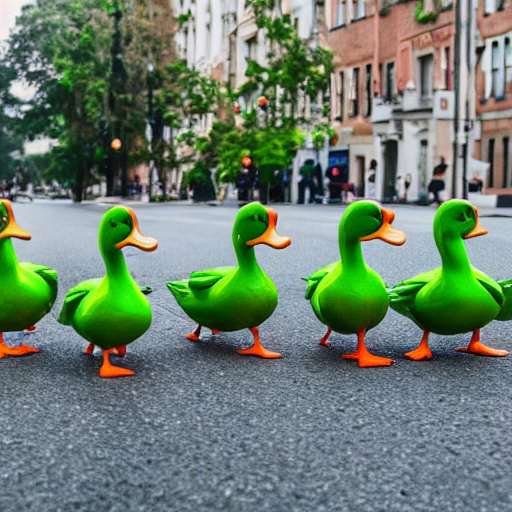

In [4]:
g_cpu = torch.Generator().manual_seed(42)
prompts = ['a photo of green ducks walking on street']
controller = AttentionStore()
image, x_t = run_and_display(prompts, controller, latent=None, run_baseline=False, generator=g_cpu)
ptp_utils.view_images(image)


  0%|          | 0/50 [00:00<?, ?it/s]

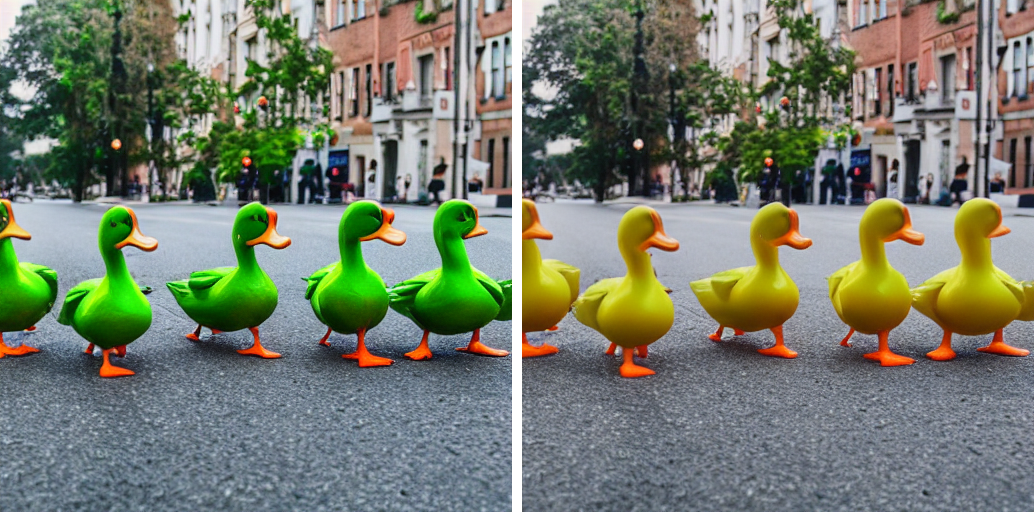

In [5]:
prompts = ['a photo of green ducks walking on street',
    'a photo of rubber ducks walking on street',
           ]

self_replace_steps = .8
NUM_DIFFUSION_STEPS = 50
controller = SelfAttentionControlEdit(prompts, NUM_DDIM_STEPS, self_replace_steps=self_replace_steps)
image, _ = run_and_display(prompts, controller, latent=x_t)
ptp_utils.view_images([image[0],image[1]])
